# Tutorial 2, Analysis of quantic trajectories of atoms in a cavity to infer the numbers of photons in the cavity

In [1]:


import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import numpy.matlib
import csv
import pandas as pd

#2 files containing  atomic detections in  (ground state) 'stateG.dat' or 'stateE.dat'


# they are a matrix Nex x T where Nex=2000 is the number of independent experiments
#each  of such trajectory  (rows of the matrix) having  T=10000 detections d,  d=0,1,2,3.. 
#indicating the number of atoms detecyed in the corresponding g,e state.



T=10000
Nex=2000

#Open and read the files:

f0=open("Data/stateG.dat")

l=0

d0=np.zeros((Nex,T)).astype(int)
for row in csv.reader(f0):
    #print((row[1:10]))
    d0[l,:]=row
    l=l+1
    
f1=open("Data/stateE.dat")

l=0
d1=np.zeros((Nex,T)).astype(int)
for row in csv.reader(f1):
    #print((row[1:10]))
    d1[l,:]=row
    l=l+1
    

ns = np.array([0,1,2,3,4,5,6,7])
Phi = np.pi * 0.223
phi = [-0.836,0.033,0.905,1.442]
A = 0.551
B = 0.698



In [2]:
#check reading of data
print(np.size(d0,1))
print((row[1:10]))
print(np.max(d1))

10000
['0', '1', '0', '0', '0', '0', '0', '0', '0']
5


Question 1 \
\
(a) Define $e_t$ and $g_t$ the number of atoms in each state detected ad measurement t \
$P(T|\phi, n) = \prod_t \frac{(g_t + e_t)!}{g_t!e_t!}(A-\frac{B}{2}\cos(n\Phi + \phi_t))^{g_t}(1-A+\frac{B}{2}\cos(n\Phi + \phi_t))^{e_t} $
By Bayes rule with prior $P(n) = \frac{1}{8} \
$P(n|T,\phi) = C_{Norm} \prod_t (A-\frac{B}{2}\cos(n\Phi + \phi_t))^{g_t}(1-A+\frac{B}{2}\cos(n\Phi + \phi_t))^{e_t} $ \
$ = C_{Norm} \prod_{k=0}^3 (A-\frac{B}{2}\cos(n\Phi + \phi_k))^{c_g^k}(1-A+\frac{B}{2}\cos(n\Phi + \phi_k))^{c_e^k}$ \
\
(b) $\ln(P(n|T,\phi)) = \ln(C_{Norm}) + \sum_{k=0}^3 (c_g^k\ln(A-\frac{B}{2}\cos(n\Phi + \phi_k)) + c_e^k\ln(1-A+\frac{B}{2}\cos(n\Phi + \phi_k))) $


Question 2

In [3]:
def loglik(count0,count1):
    # Parameters corresponding to the experimental conditions
    a=0.551
    b=0.698
    theta=(-0.836, 0.033, 0.905,1.442)
    fi_0=0.233*np.pi
    
    #compute the probability as sum of  logarithm of probabilities of all possible detections 
    #( 4 phases and 2 spin values , for all possible number of photons from 0 to 7 )

    lp=np.zeros(8)
    for n in range (8):
        lp1=0
        lp0=0
        for i in range (4):
            lp0+=count0[i]*np.log(a-b*np.cos(n*fi_0+theta[i])/2)
            lp1+=count1[i]*np.log(1-a+b*np.cos(n*fi_0+theta[i])/2)
        #print(i,n,lp0,lp1)
            
        lp[n]=lp0+lp1
      
    return lp

In [4]:
def get_count(ex,tin,tf,d0,d1):
    # ind take the data for each of the 4 phases theta (different experimental detection directions)
    #which are repeated cyclically in each row #theta=1,2,3,4,1,2,3,4 ..)
    #count0 and count1: count the total number of detections of spin1 and spin0 in each conditions
    count0=np.zeros(4)
    count1=np.zeros(4)
    for i in range (4):
        ind=list(range(i+tin,tf,4))
        count0[i]=sum(d0[ex,ind])
        count1[i]=sum(d1[ex,ind])
    return count0,count1

In [5]:
def entropy(p):
    return -np.dot(p,np.log(p))

In [6]:
#Count how many atoms are detected in the state g and e respectively

ex=1163
#ex=1293
#ex=1146
#ex=1266
#ex=479
#ex=407
tin=400
M=400
[count0,count1]=get_count(ex,tin,tin+M,d0,d1)

#verifiy sum is almost constant: the number of atom sent
print('count G', count0)
print('count E',count1)
print('counts G + counts E for each phase:')
for k in range (4):
  print ('phase', k, count0[k]+count1[k] )
print ('total number of atoms in a trajectory of', M,'detections:', sum (count0+count1))

count G [31. 17. 22. 15.]
count E [ 5.  6.  7. 26.]
counts G + counts E for each phase:
phase 0 36.0
phase 1 23.0
phase 2 29.0
phase 3 41.0
total number of atoms in a trajectory of 400 detections: 129.0


Question 3

In [7]:
tin=400

strex=str(ex)
#number of measurement starting in tin
M_v=[0,12,100,200,400]

probas_n=np.zeros((np.size(M_v),8))

for k in range (np.size(M_v)):
    [count0,count1]=get_count(ex,tin,tin+M_v[k],d0,d1)
    ll=loglik(count0,count1)
    norm=sum (np.exp(ll-np.mean(ll)))
    probas_n[k,:]=np.exp(ll-np.mean(ll))/norm

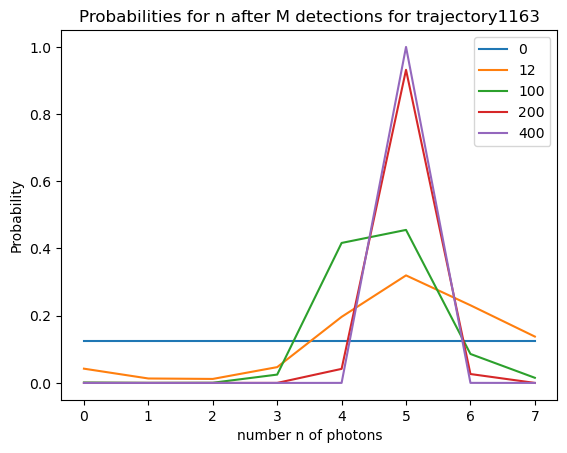

In [8]:
#plot the probabilities

plt.title('Probabilities for n after M detections for trajectory'+ strex)

plt.plot(probas_n[0,:],label=str(M_v[0]))
plt.plot(probas_n[1,:],label=str(M_v[1]))
plt.plot(probas_n[2,:],label=str(M_v[2]))
plt.plot(probas_n[3,:],label=str(M_v[3]))
plt.plot(probas_n[4,:],label=str(M_v[4]))

plt.xlabel("number n of photons")
plt.ylabel("Probability")
plt.legend()
plt.show()

Question 4

In [9]:
#Compute the entropy of the posterior
S=np.zeros(5)
for k in range (5):
    S[k]=-np.dot(probas_n[k,:],np.log(probas_n[k,:]))

initial entropy 2.0794415416798357
Entropy as a function of number of measures S: [2.07944154e+00 1.68367860e+00 1.10363515e+00 2.95253176e-01
 2.06049433e-03]


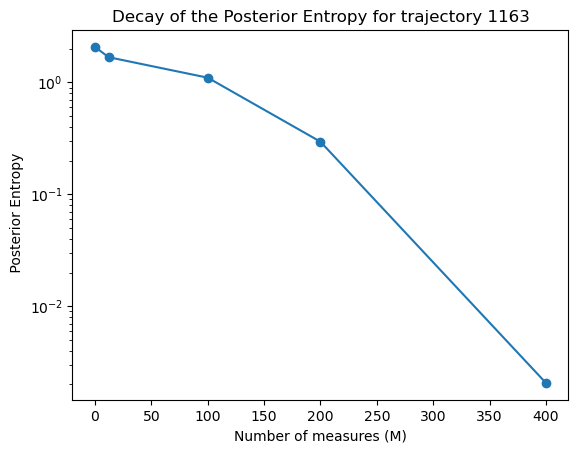

In [10]:
#Print the decay of the entropy posterior
print('initial entropy', np.log(8))    
print('Entropy as a function of number of measures S:',S)

plt.title('Decay of the Posterior Entropy for trajectory '+ strex)
plt.yscale('log')
plt.plot(M_v,S,'-o')
plt.xlabel("Number of measures (M)")
plt.ylabel(" Posterior Entropy")
plt.show()

Question 5

In [11]:
#Computation of optimal n in sliding windows of M=400 measurements for some trajectories

exs = [407,479,1146,1163,1293]
M=400



#this is for the time in seconds
dx=0.7/(int(T)-M*4)

xt = {}
nopt = {}

for ex in exs:
    tin=0
    nopt[str(ex)]=np.zeros(int(T/4)-M)
    xt[str(ex)]=np.zeros(int(T/4)-M)
    for k in range (int(T/4)-M):
        [count0,count1]=get_count(ex,tin,tin+M,d0,d1)
        xt[str(ex)][k]=float(tin)*dx
        tin=tin+4
        ll=loglik(count0,count1)
        no=np.argmax(ll)
        nopt[str(ex)][k]=no 

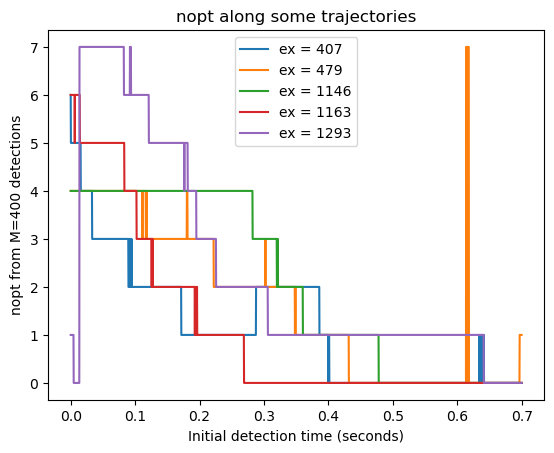

In [12]:
#Plot the nopts
plt.title('nopt along some trajectories')
for ex in exs: 
    plt.plot(xt[str(ex)],nopt[str(ex)], label='ex = ' + str(ex))
plt.xlabel("Initial detection time (seconds)")
plt.ylabel("nopt from M=400 detections")
plt.legend()
plt.show()

Question 6

In [13]:
#Make the Histogram of nopt on all experiments for the time windows starting from on the detection 16 to 1600
nopt=np.zeros(M)
tin_v=[16,400,800,1600]
nopt_av=np.zeros(np.size(tin_v))
dt=400

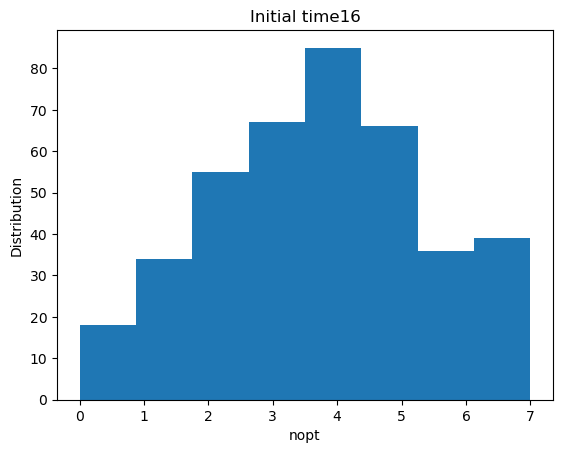

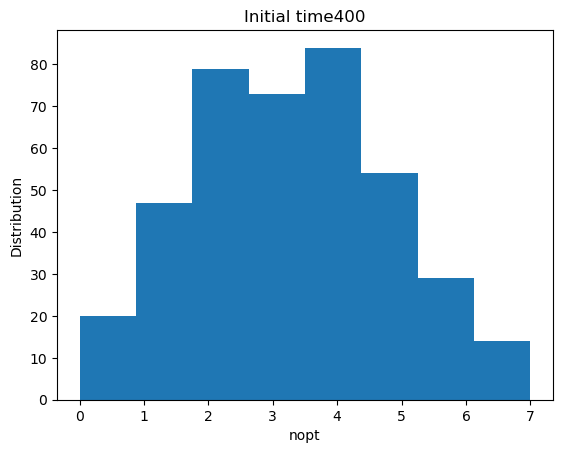

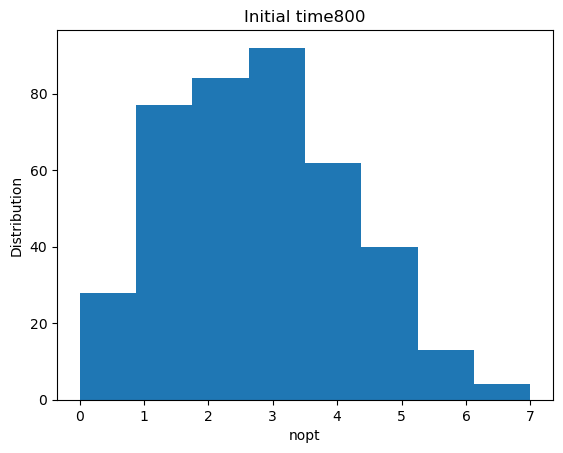

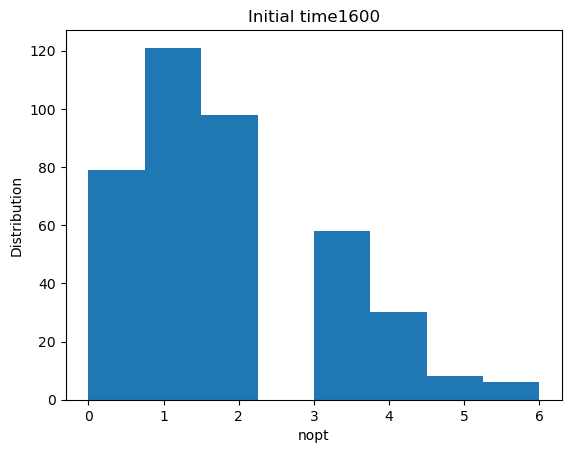

nopt_av [3.76   3.255  2.6875 1.7175]
av_nopt_av 2.855


In [14]:
for kw in range (np.size(tin_v)):
    tin=tin_v[kw]
    for kex in range (M):
        [count0,count1]=get_count(kex,tin,tin+dt,d0,d1)
        ll=loglik(count0,count1)
        no=np.argmax(ll)
        nopt[kex]=no 
    nopt_av[kw]=np.mean(nopt)
    strin=str(tin)
    plt.title('Initial time'+  strin)
    plt.hist(nopt,bins=8)
    plt.xlabel("nopt")
    plt.ylabel("Distribution")
    plt.show()
print('nopt_av',nopt_av)
print('av_nopt_av',np.mean(nopt_av))

Question 7

In [15]:
def log_likelihood(count0, count1, ramsey_phase, Phi):
    # Parameters corresponding to the experimental conditions
    A = 0.551
    B = 0.698
#    A = 0.5
#    B = 1

    # log-likelihood as function of 'n'
    lls = numpy.zeros(8)
    for n in range (8):
        ll0 = count0 * numpy.log(A - B * numpy.cos(n * Phi + ramsey_phase)/2)
        ll1 = count1 * numpy.log(1 - A + B * numpy.cos(n * Phi + ramsey_phase)/2)
        lls[n] = ll0 + ll1

    return lls

In [16]:
#Mutual Information between the quantum trajectory c and the number of photons in the cavity at fixed Ramsey phase = 1.442
#Values of 'M' we will explore
Ms = range(0, 40, 1)
ramsey_phases = numpy.array([-0.836, 0.033, 0.905, 1.442])
Phi_list = [0.4, 0.78, 1.2, 1.6, 2]

Hm = numpy.zeros((len(Ms), len(Phi_list)))

for (p, Phi) in enumerate(Phi_list):
    for (m, M) in enumerate(Ms):
        for c in range(M + 1):
            lls = log_likelihood(M - c, c, ramsey_phase=ramsey_phases[3], Phi=Phi)
            norm=sum(np.exp(lls-np.mean(lls)))
            posterior=np.exp(lls-np.mean(lls))/norm
            posterior_entropy = entropy(posterior) # entropy of P(n|c)
            Pc = numpy.exp(lls).mean() # P(c)
            Hm[m,p] = Hm[m,p] +math.comb(M,c)* Pc * posterior_entropy

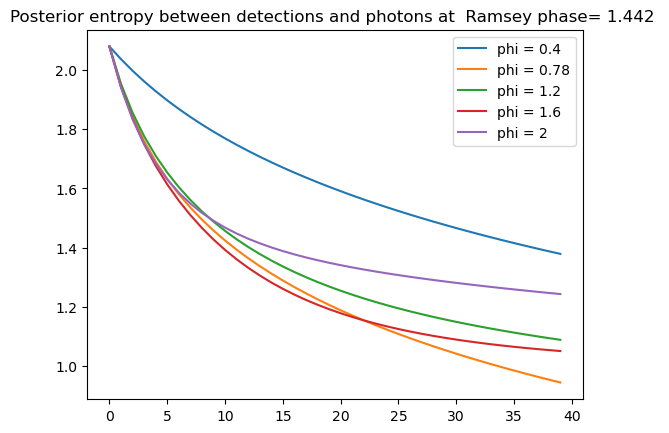

In [17]:
for p in range(len(Phi_list)):
    plt.plot(Ms, Hm[:,p], label='phi = ' + str(Phi_list[p]))
    ""
plt.title("Posterior entropy between detections and photons at  Ramsey phase= 1.442 " )
plt.legend()
plt.show()

Question 8

In [18]:
#Verify phase de ramsey p=6,7,0,1 (in order) (are choosen to have small probabilities along some n)
a=0.551
b=0.698
theta=(-0.836, 0.033, 0.905,1.442)
fi_0=0.233*np.pi
#chose a phase de Ramsey i
i=3
lp0=np.zeros(8)
lp1=np.zeros(8)
for n in range(8):
 lp0[n]=np.log(a-b*np.cos(n*fi_0+theta[i])/2)
 lp1[n]=np.log(1-a+b*np.cos(n*fi_0+theta[i])/2)
    
print (lp0)
print (lp1)


[-0.68087429 -0.28904374 -0.11613184 -0.15329116 -0.40319109 -0.87118784
 -1.44126389 -1.53313275]
[-0.70557257 -1.38222044 -2.21053324 -1.95108281 -1.10317591 -0.54206555
 -0.27001047 -0.24316563]
